<a href="https://colab.research.google.com/github/ylmgrbzz/Deep-Learning-Projects-With-Keras-TensorFlow-PyTorch/blob/main/Subject_Prediction_With_LSTM_and_Resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
dataset = pd.read_excel('/content/drive/My Drive/ylm/topic_modeling_colab.xlsx')

dataset.head()

dataset = dataset.drop(['Unnamed: 1'], axis=1)

In [6]:
dataset.head()


,Class,Text
0,government,"Corina Casanova , İsviçre Federal Şansölyesidir ."
1,government,Corina Casanova bir federal parlementerdir .
2,government,"İsviçre Dışişleri Bakanlığı , İsviçre federal ..."
3,government,İsviçre'nin dış ilişkilerini sürdürmekle görev...
4,government,"Başbakan Milan Hoda , Südet Almanlarını yatışt..."


In [5]:
dataset.describe()

,Class,Text
count,533182,533182
unique,25,532583
top,people,Türkiye Kadınlar Basketbol Ligi takımlarından ...
freq,128929,3


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


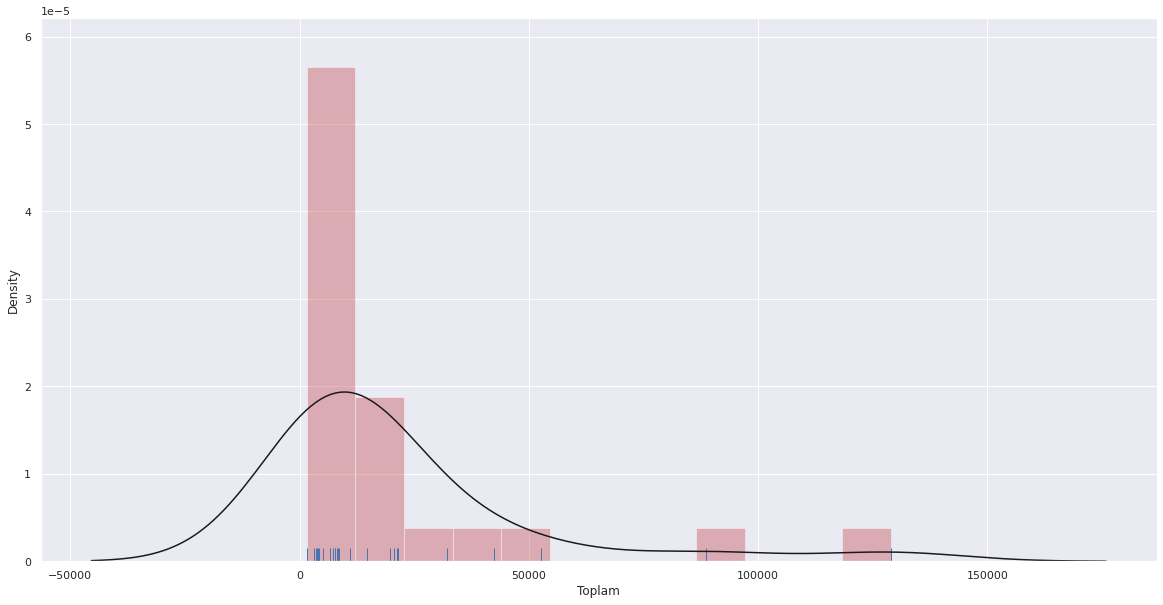

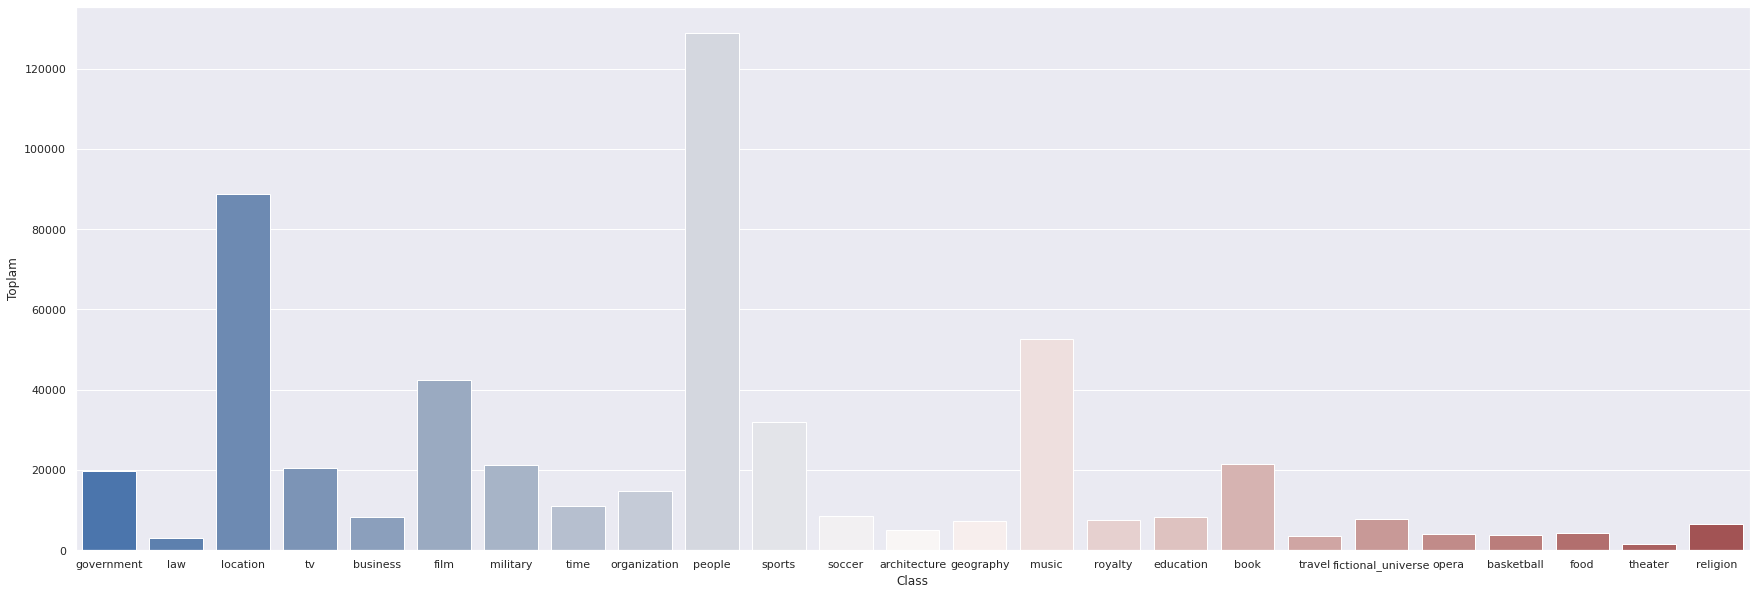

In [8]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
sum_ = Counter(dataset['Class']).values()
class_ = Counter(dataset['Class']).keys()
df_class = pd.DataFrame(zip(class_,sum_), columns = ['Class', 'Toplam'])
plt.figure(figsize=(20,10))
sns.set(color_codes=True)
sns.distplot(df_class.Toplam,rug = True, kde_kws={"color": "k"}, hist_kws={"color" : "r"});
plt.savefig('/content/drive/My Drive/ylm/sınıfdagilim2.png')
plt.figure(figsize=(30,10))
sns.set(color_codes=True)
sns.barplot(x = "Class", y = "Toplam", data = df_class, palette="vlag")
plt.savefig('/content/drive/My Drive/ylm/sınıfdagılım.png')

In [10]:
dataset['Text'] = dataset['Text'].apply(lambda x: x.lower())
# dataset['Text'] = dataset['Text'].apply(lambda x: re.sub("[,'\.!?();:$%&#]", '', x))
dataset['Text'] = dataset['Text'].apply(lambda x: x.strip())
import nltk
nltk.download('stopwords')
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')
def stopword_extraction(values):
    wordFilter = [word for word in values.split() if word not in stop_word_list]
    notStopword = " ".join(wordFilter)
    return notStopword
 
dataset['Text'] = dataset['Text'].apply(lambda x: stopword_extraction(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
pip install pad-sequences

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pad-sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10217 sha256=f7b9f1176af52e29e703e4f0f76d4b2c11993cfd37c60bed23edb4b0fb3149c0
  Stored in directory: /root/.cache/pip/wheels/3f/80/05/48e28be7b6bde8b3378f747f50bc32a87cb281c2e89ae74500
Successfully built pad-sequences


In [27]:
from tensorflow import keras

In [17]:
from keras.preprocessing.text import Tokenizer
from pad_sequences import pad_sequences_multi
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(dataset.Text)

In [22]:
import numpy as np
num_tokens = [len(tokens) for tokens in dataset['Text']]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)

In [29]:
X = tokenizer.texts_to_sequences(dataset['Text'])
X_pad =keras.preprocessing.sequence.pad_sequences(X,maxlen=max_tokens)

In [30]:
Y = pd.get_dummies(dataset['Class']).values
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_pad, Y, test_size = 0.25, random_state = 42)

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,LSTM, Dropout
from keras.optimizers import Adam
num_labes = len(dataset.Class.unique())
embedding_size = max_tokens
model = Sequential()
model.add(Embedding(input_dim=10000,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='embedding_layer'))
model.add(LSTM(units=128,dropout = 0.2, return_sequences=True))
model.add(LSTM(units=128,dropout = 0.2, return_sequences=False))
model.add(Dense(num_labes, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 325, 325)         3250000   
                                                                 
 lstm (LSTM)                 (None, 325, 128)          232448    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 25)                3225      
                                                                 
Total params: 3,617,257
Trainable params: 3,617,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, validation_split=0.20, epochs=1,batch_size=1024)
loss, acc = model.evaluate(x_test, y_test)
print(loss,acc)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 0, sampling_strategy = "majority")
x_rus, y_rus = rus.fit_resample(X_pad, Y)

In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=10000,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='embedding_layer'))
model2.add(LSTM(units=128,dropout = 0.2, return_sequences=True))
model2.add(LSTM(units=128,dropout = 0.2, return_sequences=False))
model2.add(Dense(num_labes, activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy'])
model2.summary()

In [ ]:
history2 = model2.fit(x_train, y_train, validation_split=0.20, epochs=1,batch_size=1024)

In [ ]:
loss2, acc2 = model2.evaluate(x_test, y_test)

print("loss 2 : {}, acc 2 : {}".format(loss2,acc2))

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train2', 'Test2','Train1', 'Test1'], loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')